# Using regression when data is imbalanced

## My toolkit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler

## Getting data

In [2]:
data = pd.read_csv('strokes_data.csv')

## EDA

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


## Initial cleaning steps
We're trying to retain as much data as possible (only 700 and something strokes)
- Fill null smoker status with 'unknown'
- Full null bmi with median bmi of whole data set
- Drop 'id' column
- Drop duplicates

In [5]:
data['smoking_status'].fillna('unknown', inplace=True)
data['bmi'].fillna((data['bmi'].median()), inplace=True)

In [6]:
data.drop(['id'], axis = 1, inplace = True) 

In [7]:
data.drop_duplicates(keep='first', inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                43400 non-null  float64
 9   smoking_status     43400 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


## Preprocessing
- Encode categories
- Scale numerics

### Splitting the data

In [9]:
y = data['stroke']
X = data.drop('stroke', axis=1)
X_num = X.select_dtypes(include=np.number)
X_cat = X.select_dtypes(include=object)

In [10]:
X_num.head(1)

,age,hypertension,heart_disease,avg_glucose_level,bmi
0,3.0,0,0,95.12,18.0


In [11]:
X_cat.head(1)

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,No,children,Rural,unknown


### Encoding the categorical variables

In [12]:
X_cat_dummies = pd.get_dummies(X_cat, drop_first=True)

### Aplying a scaler on numerical variables

In [13]:
scaler = RobustScaler().fit(X_num)
X_num_scaled = pd.DataFrame(scaler.transform(X_num), columns=X_num.columns)

In [14]:
X_num_scaled.shape

(43400, 5)

In [15]:
X_full = pd.concat([X_cat_dummies, X_num_scaled], axis=1)

### Train Test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.45, random_state=40)

### Defining and applying the model

In [17]:
classification = LogisticRegression(max_iter=400)

In [18]:
classification.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [19]:
y_test_pred = classification.predict(X_test)

### Assessing the accuracy of the model

In [20]:
accuracy_score(y_test, y_test_pred)

0.9820276497695852

In [21]:
data['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [22]:
# if we predict no one will have a stroke LoL
42617/(42617+783)

# We're not getting better than gesswork, which is not good

0.9819585253456221

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
confusion_matrix(y_test, y_test_pred)

array([[19179,     0],
       [  351,     0]])

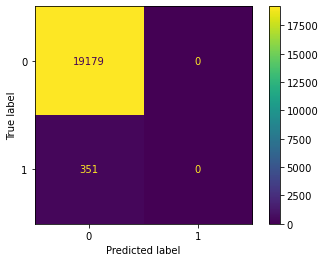

In [25]:
cmx = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cmx)
disp.plot();

**What can we do?**
- Fit the model to a more balanced data
- Increase / decrease test_size
- Try a different model
- Tweak the hyper parameters on log regression
- Change the threshold for likelihood of stroke
- Forget machine learning and go back to visualization and inference
- Forget predictions: focus on feature importance
- Work with features: create new ones, get more data, clean the data

## Resampling techniques

### Random Under Sampler

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:
rus = RandomUnderSampler()
# we can resample the whole dataframe or just the TRAIN data

In [28]:
X_full_y = pd.concat([X_full, y], axis=1)

In [29]:
X_rus, y_rus = rus.fit_resample(X_full, y)

In [30]:
y.value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [31]:
y_rus.value_counts()

0    783
1    783
Name: stroke, dtype: int64

In [32]:
X_rus.shape

(1566, 16)

### Random Over Sampler

In [33]:
from imblearn.over_sampling import RandomOverSampler

In [34]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_full, y)

In [35]:
y_ros.value_counts()

0    42617
1    42617
Name: stroke, dtype: int64

In [36]:
X_ros.shape

(85234, 16)

## Trying our model with rus and ros

In [37]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.45, random_state=40)
classification = LogisticRegression(max_iter=400)
classification.fit(X_train_rus, y_train_rus)
y_test_pred_rus = classification.predict(X_test_rus)
accuracy_score(y_test_rus, y_test_pred_rus)

0.7687943262411348

In [38]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.45, random_state=40)
classification = LogisticRegression(max_iter=400)
classification.fit(X_train_ros, y_train_ros)
y_test_pred_ros = classification.predict(X_test_ros)
accuracy_score(y_test_ros, y_test_pred_ros)

0.7801647721347377

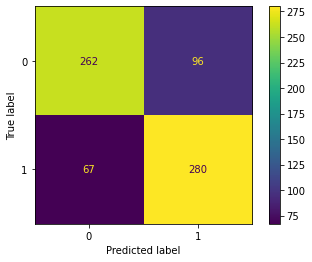

In [41]:
cmx_rus = confusion_matrix(y_test_rus, y_test_pred_rus)
disp = ConfusionMatrixDisplay(confusion_matrix=cmx_rus)
disp.plot();

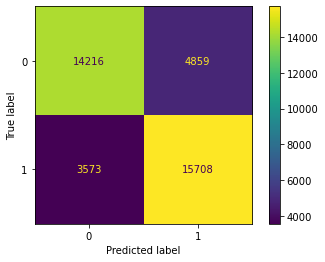

In [42]:
cmx_ros = confusion_matrix(y_test_ros, y_test_pred_ros)
disp = ConfusionMatrixDisplay(confusion_matrix=cmx_ros)
disp.plot();

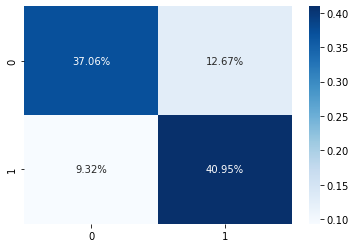

In [44]:
sns.heatmap(cmx_ros/np.sum(cmx_ros), annot=True, fmt='.2%', cmap='Blues');

# Correlating categories
- Use corr matrix heatmap for numbers
- Tip: duplicate binary y label in to a numeric field first so it appears in the corr matrix
- Use Chi-squared or ViF or randomforest_featureselection() for categories

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                43400 non-null  float64
 9   smoking_status     43400 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


## Chi squared
- Cross tabulate the incidence of each category
- Start with a pair of features: something we think might be correlated beforehand?
- Work out chi squared statistic

In [50]:
# work type and residence type
feat_crosstab = pd.crosstab(data['work_type'], data['Residence_type'], margins=False)
feat_crosstab

Residence_type,Rural,Urban
work_type,,
Govt_job,2714,2726
Never_worked,84,93
Private,12320,12514
Self-employed,3444,3349
children,3082,3074


H0 = null hypothesis, there is no dependency. In this case, no correlation between these features.
HA = alternative hypothesis - there is correlation between these features.

In [51]:
from scipy.stats import chi2_contingency
chi2_contingency(feat_crosstab, correction=False)
# first value is chi-squared, second is p-value, next one is degrees of freedom. Decisions based on p-value.

(3.0495585904185893,
 0.5495664171321049,
 4,
 array([[ 2712.98064516,  2727.01935484],
        [   88.2716129 ,    88.7283871 ],
        [12384.95612903, 12449.04387097],
        [ 3387.73483871,  3405.26516129],
        [ 3070.05677419,  3085.94322581]]))

## AUC

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve

In [57]:
y_pred_probs = classification.predict_proba(X_test_ros)[::,1]

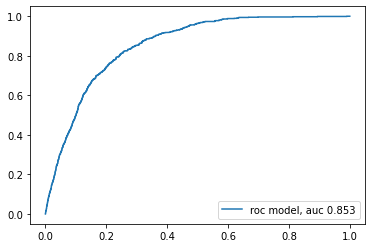

In [68]:
fpr, tpr, _ = roc_curve(y_test_ros, y_pred_probs)
auc = roc_auc_score(y_test_ros, y_pred_probs)
plt.plot(fpr, tpr, label='roc model, auc '+ str(round(auc, 3)))
plt.legend(loc=4)
plt.show();